### Visualize Features of Active Molecules using Random Forest Classifier 
###  Database: Bioactivity data MAP Kinase ERK2 from ChEMBL

### Import Libraries and read file

In [1]:
import pandas as pd
import numpy as np

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import rdBase
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from molvs import standardize_smiles

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [2]:
x=pd.read_csv('erk2.csv')
x.head(2)

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties
0,CHEMBL440356,NaN,0.0,243.06,0,1.09,2,O=C1CCNC(=O)c2[nH]c(Br)cc21,IC50,'=',...,MAP kinase ERK2,Homo sapiens,SINGLE PROTEIN,CHEMBL1135814,1.0,Scientific Literature,J. Med. Chem.,2002.0,None,NaN
1,CHEMBL260417,NaN,0.0,373.21,0,3.44,SB-725317,O=C(Nc1n[nH]c2nc(-c3ccc(O)cc3)c(Br)cc12)C1CC1,Inhibition,'=',...,MAP kinase ERK2,Homo sapiens,SINGLE PROTEIN,CHEMBL1961873,16.0,GSK Published Kinase Inhibitor Set,NaN,NaN,None,NaN


### Data preprocessing

In [3]:
x1=x[['Molecule ChEMBL ID', 'Smiles', 'Standard Type', 'Standard Value','Standard Units']]
x1=x1[x1['Standard Units'].str.contains('nM', na=False)]
x1.drop_duplicates(inplace=True)
print(x1.shape)
x1.head(2)

(18810, 5)


,Molecule ChEMBL ID,Smiles,Standard Type,Standard Value,Standard Units
0,CHEMBL440356,O=C1CCNC(=O)c2[nH]c(Br)cc21,IC50,539.0,nM
2,CHEMBL213451,CCNc1nnc2ccc(-c3ocnc3-c3ccc(F)cc3)cn12,IC50,10000.0,nM


In [4]:
x1.isnull().apply(pd.value_counts)

,Molecule ChEMBL ID,Smiles,Standard Type,Standard Value,Standard Units
False,18810.0,18762,18810.0,18806,18810.0
True,NaN,48,NaN,4,NaN


In [5]:
x1.dropna(inplace=True)
x1.shape

(18758, 5)

In [6]:
x1['New Std_value']=x1.groupby('Molecule ChEMBL ID')['Standard Value'].transform('mean')
x1=x1.drop_duplicates('Molecule ChEMBL ID', keep='first')
x1=x1.sort_values('New Std_value', ascending=True).reset_index(drop=True)
x1=x1.drop(['Standard Type', 'Standard Value', 'Standard Units'], axis=1)
print(x1.shape)
x1.head(3)

(17739, 3)


,Molecule ChEMBL ID,Smiles,New Std_value
0,CHEMBL4868141,Nc1ncc(-c2ccc(NS(=O)(=O)C3CC3)cc2OC2CCCCC2)cc1...,-29600.00000
1,CHEMBL4115001,Nc1ncc([C@@H]2CC[C@@H](O)[C@H](O)C2)nc1-c1ccc(...,0.00431
2,CHEMBL4111166,NC[C@@H](NC(=O)c1ccc(-c2nc([C@@H]3CC[C@@H](O)[...,0.00500


### Seggregate data into Actives (Label = 1)and Inactives (Label = 0)

In [7]:
x1['Label']=x1['New Std_value'].apply(lambda x: 1 if x <=10000 else 0)
x1.head()

,Molecule ChEMBL ID,Smiles,New Std_value,Label
0,CHEMBL4868141,Nc1ncc(-c2ccc(NS(=O)(=O)C3CC3)cc2OC2CCCCC2)cc1...,-29600.00000,1
1,CHEMBL4115001,Nc1ncc([C@@H]2CC[C@@H](O)[C@H](O)C2)nc1-c1ccc(...,0.00431,1
2,CHEMBL4111166,NC[C@@H](NC(=O)c1ccc(-c2nc([C@@H]3CC[C@@H](O)[...,0.00500,1
3,CHEMBL3904235,Nc1ncc([C@H]2CC[C@H](O)[C@@H](O)C2)nc1-c1ccc(C...,0.00550,1
4,CHEMBL3980387,NC[C@@H](NC(=O)c1ccc(-c2nc(C3CCOCC3)cnc2N)cc1F...,0.00612,1


In [8]:
x1['Label'].value_counts()

0    10534
1     7205
Name: Label, dtype: int64

### Standardize Smiles

In [9]:
std_smiles=[standardize_smiles(smi) for smi in x1['Smiles'] if smi is not None]

In [10]:
std_smi=pd.DataFrame(std_smiles, columns=['Std_Smiles'])
x2=pd.concat([x1[['Molecule ChEMBL ID', 'New Std_value', 'Label']],std_smi],axis=1)
x2.drop_duplicates('Std_Smiles', keep='first', inplace=True)
print(x2.shape)
x2.head()

(17738, 4)


,Molecule ChEMBL ID,New Std_value,Label,Std_Smiles
0,CHEMBL4868141,-29600.00000,1,Nc1ncc(-c2ccc(NS(=O)(=O)C3CC3)cc2OC2CCCCC2)cc1...
1,CHEMBL4115001,0.00431,1,Nc1ncc([C@@H]2CC[C@@H](O)[C@H](O)C2)nc1-c1ccc(...
2,CHEMBL4111166,0.00500,1,NC[C@@H](NC(=O)c1ccc(-c2nc([C@@H]3CC[C@@H](O)[...
3,CHEMBL3904235,0.00550,1,Nc1ncc([C@H]2CC[C@H](O)[C@@H](O)C2)nc1-c1ccc(C...
4,CHEMBL3980387,0.00612,1,NC[C@@H](NC(=O)c1ccc(-c2nc(C3CCOCC3)cnc2N)cc1F...


In [11]:
x2[['Std_Smiles','Label']].to_csv('erk2_labelled.smi', sep='\t', index=None, header=None)

### Identify top 50 features by applying RandomForest Classifier

In [12]:
X_train,X_test,y_train,y_test=train_test_split(x2['Std_Smiles'], x2['Label'], test_size=0.30, random_state=42)

In [13]:
train=pd.concat([X_train,y_train], axis=1)
test=pd.concat([X_test,y_test], axis=1)

In [14]:
train.to_csv('train.smi', sep='\t', header=None, index=None)
test.to_csv('test.smi', sep='\t', header=None, index=None)

In [15]:
train_mols=Chem.SmilesMolSupplier('train.smi', delimiter='\t', titleLine=False)
test_mols=Chem.SmilesMolSupplier('test.smi', delimiter='\t', titleLine=False)

In [16]:
train_morgan_fp=[AllChem.GetMorganFingerprintAsBitVect(mol,2,nBits=1024) for mol in train_mols]
test_morgan_fp=[AllChem.GetMorganFingerprintAsBitVect(mol,2,nBits=1024) for mol in test_mols]

In [17]:
train_labels=[mol.GetProp('_Name') for mol in train_mols]
test_labels=[mol.GetProp('_Name') for mol in test_mols]

In [18]:
train_X=np.asarray(train_morgan_fp, dtype=np.int32)
test_X=np.asarray(test_morgan_fp, dtype=np.int32)

In [19]:
train_y=np.asarray(train_labels, dtype=np.int32).reshape(-1,1)
test_y=np.asarray(test_labels, dtype=np.int32).reshape(-1,1)

In [20]:
clf=RandomForestClassifier(n_estimators=50)
clf.fit(train_X,train_y.ravel())

RandomForestClassifier(n_estimators=50)

In [21]:
predict_y=clf.predict(test_X)

In [22]:
print('Accuracy:', roc_auc_score(test_y, predict_y))

Accuracy: 0.7373817963384154


In [23]:
impFeatures=clf.feature_importances_
impFeatures_dict=dict(enumerate(impFeatures.flatten(), 1))
impFeatures_sorted=sorted(impFeatures_dict.items(), key=lambda x:x[1], reverse=True)

In [24]:
top50=[x[0] for x in impFeatures_sorted[:50]]
print(top50)

[966, 569, 2, 512, 120, 75, 429, 76, 292, 379, 118, 261, 342, 981, 366, 37, 324, 129, 137, 334, 436, 959, 700, 195, 894, 876, 767, 330, 223, 89, 558, 91, 983, 559, 808, 947, 793, 832, 390, 65, 198, 897, 672, 176, 34, 696, 699, 651, 905, 323]


### Visualize important features on a test molecule

In [25]:
test_active_idx=[]
for i,l in enumerate(test_y):
    if l==[1]:
        test_active_idx.append(i)       

In [53]:
result=clf.predict(test_X[test_active_idx[12]].reshape(1,-1))
result

array([1])

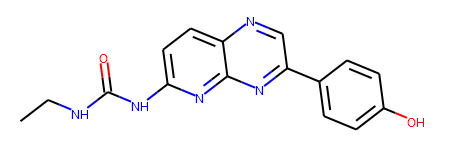

In [55]:
test=test_mols[test_active_idx[12]]
test

In [56]:
bitinfo={}
test_fp=[AllChem.GetMorganFingerprintAsBitVect(test, 2, nBits=1024, bitInfo=bitinfo)]
onBits=[bit for bit in bitinfo.keys()]
print(onBits)

[33, 73, 75, 80, 98, 128, 136, 168, 197, 238, 267, 289, 294, 312, 356, 378, 428, 485, 511, 578, 600, 650, 702, 709, 726, 745, 754, 773, 792, 807, 831, 849, 893, 896, 905, 945, 946, 947, 961, 965, 967, 980]


In [57]:
commonOnBits=list(set(top50) & set(onBits))
commonOnBits

[905, 75, 947]

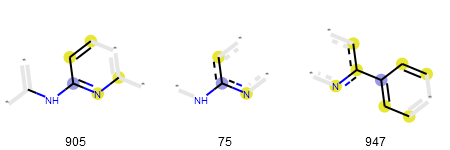

In [58]:
commonOnBits_=[[test, x, bitinfo] for x in commonOnBits]
Draw.DrawMorganBits(commonOnBits_, legends=[str(x) for x in commonOnBits])